# Importaciones

Primero, se da acceso al drive en donde están alojadas las imágenes y donde se almacenará el futuro modelo.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Se importan bibliotecas esenciales para manipulación de imágenes (cv2), sistema de archivos (os), operaciones numéricas (numpy), TensorFlow/Keras para el modelo, visualización (matplotlib, seaborn), manejo de datos (pandas), utilidades (glob, collections, itertools), y herramientas específicas de Colab.

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import os
from tqdm import tqdm
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, save_img
from tensorflow.keras.layers import Conv2D
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import load_model, Sequential
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import itertools
import glob
%matplotlib inline

# Mapeo de Personajes

Se define un mapeo entre los nombres de los personajes y los IDs numéricos, almacenado en el diccionario MAP_CHARACTERS.  También se define el tamaño estándar al que se redimensionarán todas las imágenes, IMG_SIZE, para asegurar que todas tengan la misma dimensión al ingresar al modelo.

In [ ]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel',
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson',
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak',
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Vamos a standarizar todas las imágenes a tamaño 64x64
IMG_SIZE = 64

# Funciones de carga de personajes

Se definen dos funciones clave: load_train_set y load_test_set. La primera carga las imágenes de entrenamiento, las redimensiona y asigna etiquetas numéricas. La segunda hace lo mismo para las imágenes de prueba. Ambas funciones utilizan OpenCV para leer y redimensionar las imágenes.

In [ ]:
def load_train_set(dirname, map_characters, verbose=True):
    """Esta función carga los datos de training en imágenes.

    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.

    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas

    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    for label, character in map_characters.items():
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

In [ ]:
def load_test_set(dirname, map_characters, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)

# Aumentación de imágenes

Se aplica aumento de datos utilizando la clase ImageDataGenerator de Keras. Esto genera versiones modificadas de las imágenes de entrenamiento (rotadas, desplazadas, etc.) para aumentar la diversidad del conjunto de datos y mejorar la generalización del modelo.

In [ ]:
# Ruta al dataset
dataset_path = "/content/drive/MyDrive/Barsinson/simpsons/simpsons_dataset"  # <-- AJUSTA

# Cantidad mínima requerida
target_per_class = 2246

# Configuración de augmentación
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Obtener nombres de clases
clases = ['abraham_grampa_simpson','apu_nahasapeemapetilon','bart_simpson', 'charles_montgomery_burns','chief_wiggum','comic_book_guy','edna_krabappel',
    'homer_simpson','kent_brockman','krusty_the_clown','lisa_simpson','marge_simpson','milhouse_van_houten','moe_szyslak',
    'ned_flanders', 'nelson_muntz', 'principal_skinner', 'sideshow_bob']

print(f"🔍 Detectadas {len(clases)} clases.\n")

# Recorrer todas las clases
for clase in clases:
    clase_path = os.path.join(dataset_path, clase)
    imagenes = [f for f in os.listdir(clase_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    cantidad_actual = len(imagenes)

    print(f"📂 Clase: {clase} | Imágenes: {cantidad_actual}", end='')

    if cantidad_actual >= target_per_class:
        print(" ✅ Suficiente")
        continue

    print(f" ⚠️ Incompleto → Generando {target_per_class - cantidad_actual} imágenes")

    total_necesarias = target_per_class - cantidad_actual
    total_generadas = 0
    imagen_idx = 0

    pbar = tqdm(total=total_necesarias, desc=f"🧪 {clase}", leave=False)
    while total_generadas < total_necesarias:
        img_path = os.path.join(clase_path, imagenes[imagen_idx % len(imagenes)])
        img = load_img(img_path)
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)

        # Generar una sola imagen por loop
        for batch in datagen.flow(x, batch_size=1):
            new_filename = f"aug_{total_generadas + cantidad_actual:05d}.jpg"
            save_img(os.path.join(clase_path, new_filename), batch[0])
            total_generadas += 1
            pbar.update(1)
            break  # Generar solo una imagen por iteración

        imagen_idx += 1
    pbar.close()

print("\n✅ Augmentación completada para todas las clases faltantes.")


🔍 Detectadas 18 clases.

📂 Clase: abraham_grampa_simpson | Imágenes: 2281 ✅ Suficiente
📂 Clase: apu_nahasapeemapetilon | Imágenes: 2246 ✅ Suficiente
📂 Clase: bart_simpson | Imágenes: 2246 ✅ Suficiente
📂 Clase: charles_montgomery_burns | Imágenes: 2246 ✅ Suficiente
📂 Clase: chief_wiggum | Imágenes: 2246 ✅ Suficiente
📂 Clase: comic_book_guy | Imágenes: 2246 ✅ Suficiente
📂 Clase: edna_krabappel | Imágenes: 2246 ✅ Suficiente
📂 Clase: homer_simpson | Imágenes: 2246 ✅ Suficiente
📂 Clase: kent_brockman | Imágenes: 2246 ✅ Suficiente
📂 Clase: krusty_the_clown | Imágenes: 2246 ✅ Suficiente
📂 Clase: lisa_simpson | Imágenes: 2246 ✅ Suficiente
📂 Clase: marge_simpson | Imágenes: 2246 ✅ Suficiente
📂 Clase: milhouse_van_houten | Imágenes: 2246 ✅ Suficiente
📂 Clase: moe_szyslak | Imágenes: 2246 ✅ Suficiente
📂 Clase: ned_flanders | Imágenes: 2246 ✅ Suficiente
📂 Clase: nelson_muntz | Imágenes: 2246 ✅ Suficiente
📂 Clase: principal_skinner | Imágenes: 2246 ✅ Suficiente
📂 Clase: sideshow_bob | Imágenes: 224

# Carga de datos

Se cargan los datos de entrenamiento y prueba utilizando las funciones definidas previamente, adaptando las rutas en Colab.

In [ ]:
# Cargamos los datos. Si no estás trabajando en colab, cambia los paths por
# los de los ficheros donde hayas descargado los datos.
DATASET_TRAIN_PATH_COLAB = "/content/drive/MyDrive/Barsinson/simpsons/simpsons_dataset"
DATASET_TEST_PATH_COLAB = "/content/drive/MyDrive/Barsinson/simpsons/kaggle_simpson_testset/kaggle_simpson_testset"

X, y = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
X_t, y_t = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)

Leyendo 2281 imágenes encontradas de abraham_grampa_simpson
Leyendo 2246 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 2246 imágenes encontradas de bart_simpson
Leyendo 2246 imágenes encontradas de charles_montgomery_burns
Leyendo 2246 imágenes encontradas de chief_wiggum
Leyendo 2246 imágenes encontradas de comic_book_guy
Leyendo 2246 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 2246 imágenes encontradas de kent_brockman
Leyendo 2246 imágenes encontradas de krusty_the_clown
Leyendo 2246 imágenes encontradas de lisa_simpson
Leyendo 2246 imágenes encontradas de marge_simpson
Leyendo 2246 imágenes encontradas de milhouse_van_houten
Leyendo 2246 imágenes encontradas de moe_szyslak
Leyendo 2246 imágenes encontradas de ned_flanders
Leyendo 2246 imágenes encontradas de nelson_muntz
Leyendo 2246 imágenes encontradas de principal_skinner
Leyendo 2246 imágenes encontradas de sideshow_bob
Leídas 890 imágenes de test


# Normalización y creación de datasets

Se normalizarán los datos. Luego, se realizará el one hot encoding para poder categorizar las imágenes.

In [ ]:
#Normalización
entrenar = X.astype('float32')/255.0
testear = X_t.astype('float32')/255.0

In [ ]:
#One hot encoding
from tensorflow import keras
from keras.utils import to_categorical
y = to_categorical(y)
perm = np.random.permutation(len(entrenar))
entrenamiento, label = entrenar[perm], y[perm]
image_size = (64, 64, 3)

# Arquitectura de Modelo Convolucional

Se define la arquitectura del modelo CNN utilizando Keras. El modelo incluye capas convolucionales para extraer características, capas de pooling para reducir la dimensionalidad, capas de normalización y dropout para regularización, y capas densas para la clasificación final. Se compila el modelo especificando el optimizador, la función de pérdida y las métricas de evaluación.

Se utilizan callbacks durante el entrenamiento. EarlyStopping detiene el entrenamiento si el rendimiento en el conjunto de validación deja de mejorar, ModelCheckpoint guarda el mejor modelo obtenido durante el entrenamiento y ReduceLROnPlateau reduce el learning rate del modelo si no mejora durante 3 épocas.

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=image_size, activation="relu"))
model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(256, (3, 3), padding='same', activation="relu"))
model.add(Conv2D(256, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(18, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#Checkpoints
MODEL_PATH = "/content/drive/MyDrive/Barsinson/model.keras"
model = load_model(MODEL_PATH)
lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
        )

checkpoint_model = ModelCheckpoint(
        filepath=MODEL_PATH,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )

early_stop = EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )

# Entrenamiento del modelo

Se entrena el modelo utilizando el método fit() con los generadores de datos definidos anteriormente, especificando el número de épocas, los pasos por época y los datos de validación.

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer="adam",metrics=['accuracy'])
history = model.fit(
    entrenamiento, label,
    batch_size=100,
    epochs=50,
    validation_split=0.2,
    callbacks=[lr_scheduler, checkpoint_model, early_stop]
    )

Epoch 1/50
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.1904 - loss: 2.5648
Epoch 1: val_accuracy improved from -inf to 0.57976, saving model to /content/drive/MyDrive/Barsinson/model.keras
324/324 ━━━━━━━━━━━━━━━━━━━━ 38s 80ms/step - accuracy: 0.1908 - loss: 2.5637 - val_accuracy: 0.5798 - val_loss: 1.4055 - learning_rate: 0.0010
Epoch 2/50
323/324 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5941 - loss: 1.3374
Epoch 2: val_accuracy improved from 0.57976 to 0.74311, saving model to /content/drive/MyDrive/Barsinson/model.keras
324/324 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.5943 - loss: 1.3365 - val_accuracy: 0.7431 - val_loss: 0.8596 - learning_rate: 0.0010
Epoch 3/50
323/324 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7500 - loss: 0.8305
Epoch 3: val_accuracy improved from 0.74311 to 0.83331, saving model to /content/drive/MyDrive/Barsinson/model.keras
324/324 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.7501 - loss: 0.8302 - val_accuracy: 0.8333 - val

# Evaluación del modelo

Finalmente, se evalúa el modelo entrenado. Se carga el mejor modelo guardado, se realizan predicciones sobre el conjunto de prueba y se calculan métricas de rendimiento como la precisión, el informe de clasificación y la matriz de confusión. La matriz de confusión se visualiza gráficamente para entender mejor los errores de clasificación del modelo.

In [ ]:
def mostrar_historial_entrenamiento(history):
    """Muestra gráficamente la evolución de las métricas durante el proceso de entrenamiento."""

    if history is None or not hasattr(history, "history"):
        print("⚠️ No se puede mostrar el historial: no hay historial de entrenamiento disponible.")
        return

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Evolución de la pérdida
    ax1.plot(history.history['loss'], label='Entrenamiento')
    ax1.plot(history.history['val_loss'], label='Validación')
    ax1.set_title('Evolución de la pérdida')
    ax1.set_xlabel('Épocas')
    ax1.set_ylabel('Pérdida')
    ax1.legend()
    ax1.grid(True)

    # Evolución de la precisión
    ax2.plot(history.history['accuracy'], label='Entrenamiento')
    ax2.plot(history.history['val_accuracy'], label='Validación')
    ax2.set_title('Evolución de la precisión')
    ax2.set_xlabel('Épocas')
    ax2.set_ylabel('Precisión')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    # Resumen de métricas clave
    epoca_max_val = np.argmax(history.history['val_accuracy'])
    acc_max_val = history.history['val_accuracy'][epoca_max_val]
    acc_final_entrenamiento = history.history['accuracy'][-1]
    acc_final_validacion = history.history['val_accuracy'][-1]

    print(f"🔹 Precisión máxima en validación: {acc_max_val:.4f} en la época {epoca_max_val+1}")
    print(f"🔹 Precisión final en entrenamiento: {acc_final_entrenamiento:.4f}")
    print(f"🔹 Precisión final en validación: {acc_final_validacion:.4f}")

    # Análisis básico del ajuste del modelo
    if acc_final_entrenamiento > acc_final_validacion + 0.1:
        print("\n🚨 Indicio de sobreajuste: el modelo rinde mejor en entrenamiento que en validación.")
        print("   Recomendaciones: aumentar regularización, usar más dropout o recopilar más datos.")
    elif acc_final_entrenamiento < 0.9 and acc_final_validacion < 0.9:
        print("\n📉 Posible subajuste: el modelo no logra capturar patrones relevantes.")
        print("   Sugerencias: probar con más capas, más épocas o ajustar el learning rate.")
    else:
        print("\n✅ Buen ajuste: el modelo presenta un desempeño equilibrado entre entrenamiento y validación.")

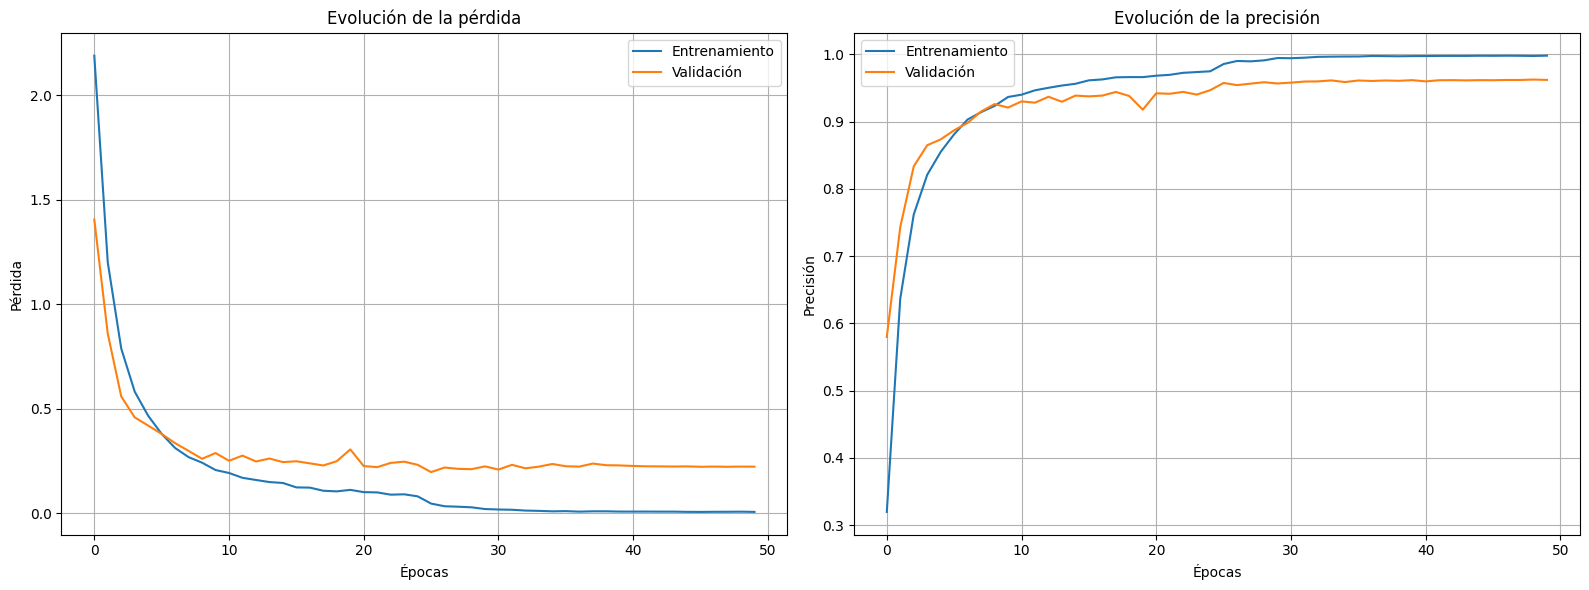

🔹 Precisión máxima en validación: 0.9624 en la época 49
🔹 Precisión final en entrenamiento: 0.9980
🔹 Precisión final en validación: 0.9619

✅ Buen ajuste: el modelo presenta un desempeño equilibrado entre entrenamiento y validación.


In [ ]:
# Llamada segura
if 'history' in locals():
    mostrar_historial_entrenamiento(history)
else:
    print("🔸 No se entrenó el modelo en esta sesión, por lo tanto no hay historial para mostrar.")

In [ ]:
# Supongamos que tu modelo se llama "model"
loss, acc = model.evaluate(testear, y_t, verbose=1)
print(f"\n📊 Pérdida (Loss): {loss:.4f}")
print(f"✅ Exactitud (Accuracy): {acc:.4f}")

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9897 - loss: 0.0542

📊 Pérdida (Loss): 0.0590
✅ Exactitud (Accuracy): 0.9888
